In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Imports and parameter defining

In [ ]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
!pip install ml_things
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW,
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)


results = {}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

learn_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]
max_lengths = [50,150,200]


set_seed(123)
epochs = 4
batch_size = 32
max_length = 150
learning_rate = 0.0001


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define model name
model_name_or_path = 'gpt2'


# string labels to number ids.
labels_ids = {'not_propaganda': 0, 'propaganda': 1}
ids_labels = {0:'not_propaganda', 1: 'propaganda'}

n_labels = len(labels_ids) # get number of labels for training, used to decide size of classification head.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Get Data


In [ ]:
class PropagandaDataset(Dataset):
  """
    PyTorch Dataset class for loading data.
  """

  def __init__(self, path, use_tokenizer):
    """
      arguments:
        path: path to partitioned, preprocessed data
    """
    # check if path exists.
    if not os.path.isdir(path):
      # raise error if path is invalid.
      raise ValueError('Invalid `path` variable! Needs to be a directory')

    self.texts = []
    self.labels = []

    # for each label...
    for label in ['not_propaganda','propaganda']:

      # Get path of that class
      propaganda_path = os.path.join(path, label)

      # Get all files from path.
      files_names = os.listdir(propaganda_path)

      # Go through each file and read its content.
      for file_name in tqdm(files_names, desc=f'{label} files'):
        file_path = os.path.join(propaganda_path, file_name)
        # Read content.
        content = io.open(file_path, mode='r', encoding='utf-8').read()
        # Fix any unicode issues.
        content = fix_text(content)
        # Save content.
        self.texts.append(content)
        # Save encode labels.
        self.labels.append(label)

      # get numbe rof labels.
      self.n_examples = len(self.labels)

    return

  def __len__(self):
    """
    returns the number of examples.
    """
    return self.n_examples

  def __getitem__(self, item):
    """
    Given an index, return an example from the position.
    """

    return {'text':self.texts[item],
            'label':self.labels[item]}



class Gpt2ClassificationCollator(object):
    """
    Data Collator.

    Uses a given tokenizer and label encoder to convert any text and labels to representation that can go straight into a GPT2 model.

    Args:

      use_tokenizer: tokenizer used to process raw text into numbers.

      labels_ids: Dictionary to encode labels to numbers.

      max_sequence_len: Value to indicate the maximum desired sequence to truncate or pad text sequences to.
    """

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):

        # Tokenizer to use
        self.use_tokenizer = use_tokenizer

        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len

        # get label encoder
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):

        # Get all texts from sequences list.
        texts = [sequence['text'] for sequence in sequences]

        # Get all labels from sequences list.
        labels = [sequence['label'] for sequence in sequences]

        # Encode all labels using label encoder.
        labels = [self.labels_encoder[label] for label in labels]

        # Call tokenizer on all texts to convert into tensors
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)

        # update inputs with encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})

        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
  """
  Train pytorch model on a single pass through the data loader.

  uses global variable 'model' which is the transformer model loaded on device_.


  Arguments:

      dataloader: Parsed data into batches of tensors.

      optimizer_: Optimizer used for training.

      scheduler_: PyTorch scheduler.

      device_: Device used to load tensors.

  Returns:

      :obj:`[True Labels, Predicted Labels, Train Average Loss].
  """

  global model

  # Tracking variables.
  predictions_labels = []
  true_labels = []

  # Total loss for this epoch.
  total_loss = 0

  # Put the model into training mode.
  model.train()

  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # clear any previously calculated gradients before performing a backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).

    # This will return the loss (rather than the model output) because we have provided the `labels`.
    outputs = model(**batch)

    # Pull loss and logits for later use
    loss, logits = outputs[:2]

    #accumulate loss.
    total_loss += loss.item()

    # Perform backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0, prevents gradients exploding.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    #optimise gradients
    optimizer_.step()

    # Update learning rate.
    scheduler_.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert logits to list of predicted labels ints.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediction for future eval.
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  r"""
  Validation function to evaluate model performance on validation set.

  Args:

    dataloader: Parsed data into batches of tensors.

    device_: Device used to load tensors.

  Returns:

    :obj: [True Labels, Predicted Labels, Average Loss]
  """

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []

  #total loss for this epoch.
  total_loss = 0

  # Put model in evaluation mode
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, don't need them for validation
    with torch.no_grad():

        # Forward pass, calculate logit predictions.
        outputs = model(**batch)

        # pull logits & loss
        loss, logits = outputs[:2]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # accumulate validation loss
        total_loss += loss.item()

        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Load Model and Trainer

In [ ]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define pad Token
tokenizer.pad_token = tokenizer.eos_token


# Get the model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to gpu.
model.to(device)
print(f'Model loaded to {device}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading configuraiton...
Loading tokenizer...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model...
Model loaded to cuda


# Load Data

In [ ]:
# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer,
                                                          labels_encoder=labels_ids,
                                                          max_sequence_len=max_length)


print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = PropagandaDataset(path='/content/drive/MyDrive/ANLE_Coursework/Data/Task-1/propaganda_train',
                               use_tokenizer=tokenizer)
print(f'Created `train_dataset` with {len(train_dataset)} examples')

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print(f'Created train_dataloader with {len(train_dataloader)} batches')

print()

print('Dealing with Validation...')
# Create pytorch dataset.
valid_dataset =  PropagandaDataset(path='/content/drive/MyDrive/ANLE_Coursework/Data/Task-1/propaganda_val',
                               use_tokenizer=tokenizer)
print(f'Created valid_dataset with {len(valid_dataset)} examples!')

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print(f'Created eval_dataloader with {len(valid_dataloader)} batches!')

Dealing with Train...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


not_propaganda files:   0%|          | 0/1191 [00:00<?, ?it/s]

propaganda files:   0%|          | 0/1223 [00:00<?, ?it/s]

Created `train_dataset` with 2414 examples
Created train_dataloader with 76 batches

Dealing with Validation...


not_propaganda files:   0%|          | 0/301 [00:00<?, ?it/s]

propaganda files:   0%|          | 0/279 [00:00<?, ?it/s]

Created valid_dataset with 580 examples!
Created eval_dataloader with 19 batches!


# Training

Epoch


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/76 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/19 [00:00<?, ?it/s]

  train_loss: 0.62168 - val_loss: 0.38578 - train_acc: 0.68144 - valid_acc: 0.81034


Training on batches...


  0%|          | 0/76 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/19 [00:00<?, ?it/s]

  train_loss: 0.33959 - val_loss: 0.63898 - train_acc: 0.84134 - valid_acc: 0.70690


Training on batches...


  0%|          | 0/76 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/19 [00:00<?, ?it/s]

  train_loss: 0.25996 - val_loss: 0.29674 - train_acc: 0.88898 - valid_acc: 0.86379


Training on batches...


  0%|          | 0/76 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/19 [00:00<?, ?it/s]

  train_loss: 0.18782 - val_loss: 0.26916 - train_acc: 0.92461 - valid_acc: 0.88966



/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


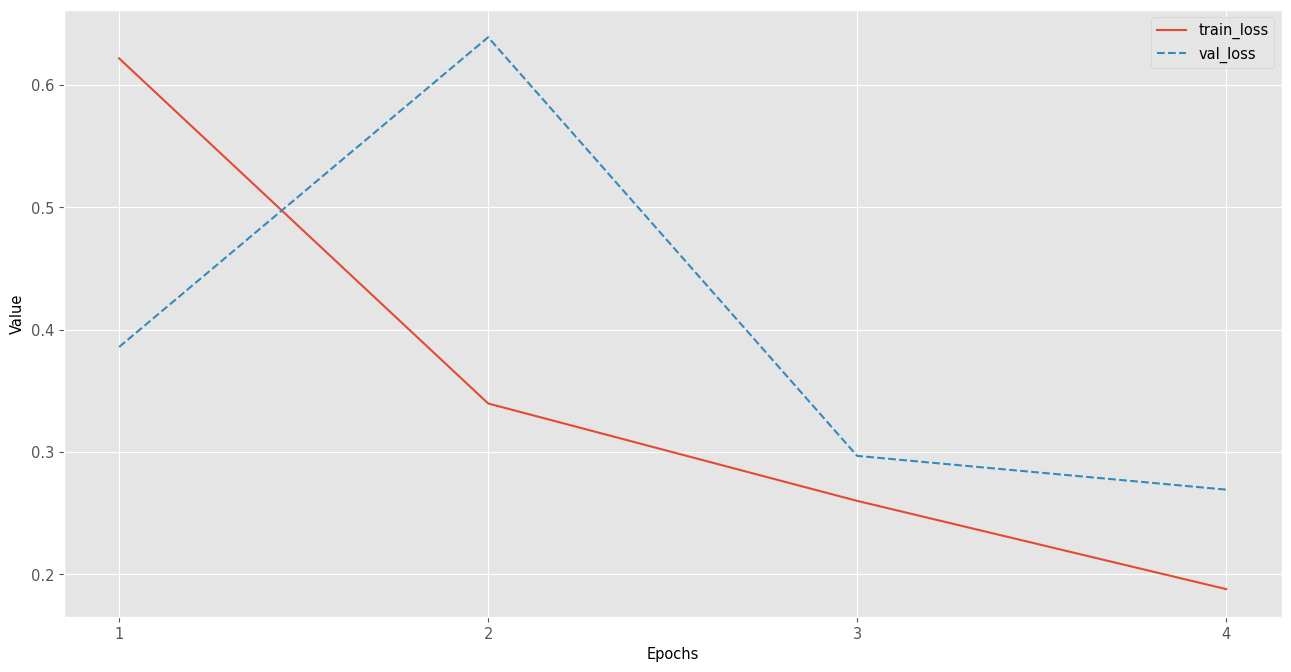

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


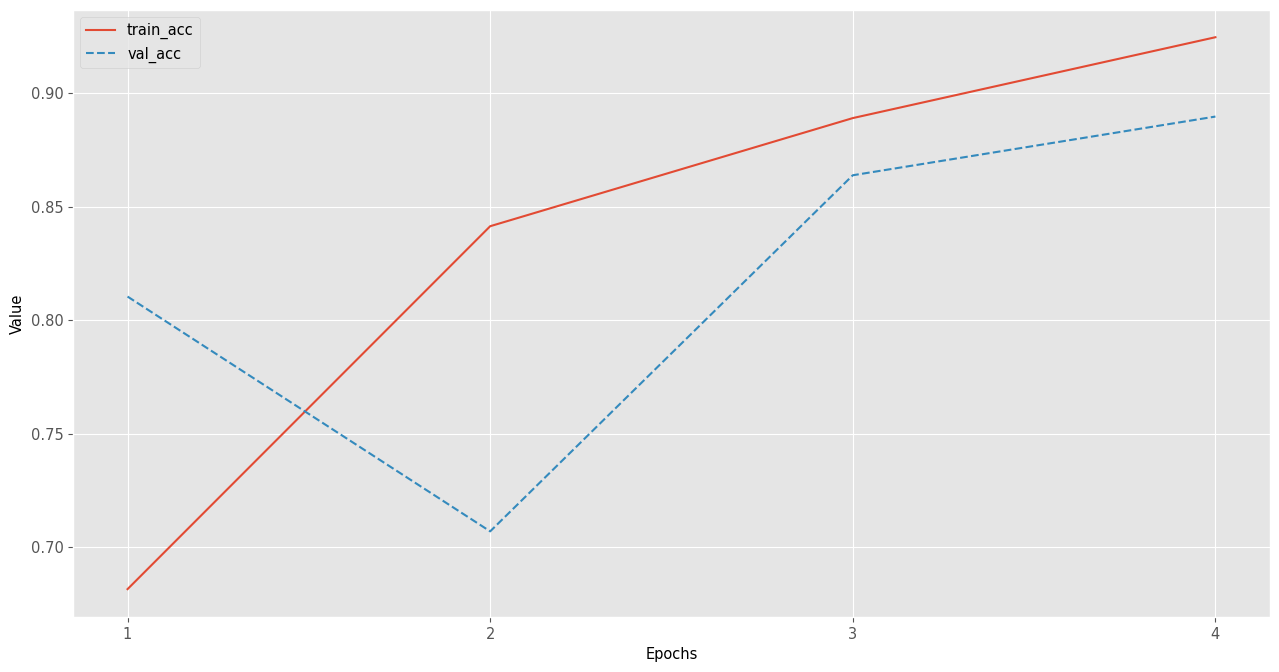

In [ ]:

# define optimiser
optimizer = AdamW(model.parameters(),
                  lr = learning_rate, # default is 5e-5,
                  eps = 1e-8 # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data.
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Evaluate

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:646: DeprecationWarning: `title` will be deprecated in future updates. Use `use_title` in stead!
  warnings.warn("`title` will be deprecated in future updates. Use `use_title` in stead!", DeprecationWarning)


Normalized confusion matrix


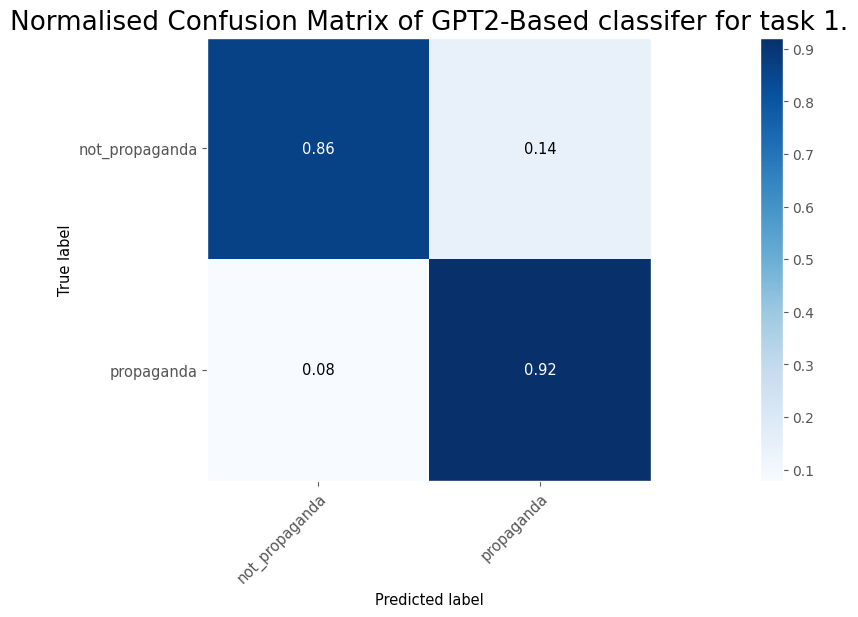

In [ ]:
import pandas as pd
from sklearn.metrics import f1_score

# Get prediction form model on validation data.
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)


# Create evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show evaluation report.
print(evaluation_report)
print(f"epochs: {epochs}, learning rate:{learning_rate}, max length:{max_length}")
# Plot confusion matrix.
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels,
                      classes=list(labels_ids.keys()), normalize=True,
                      magnify=0.1, title="Normalised Confusion Matrix of GPT2-Based classifer for task 1."
                      );



# for hypparam optmisation
macro_f1 = f1_score(true_labels, predictions_labels, average='macro')

if learning_rate not in results:
    results[learning_rate] = {}

results[learning_rate][max_length] = macro_f1

print(results)
result_df = pd.DataFrame(results)

result_df

# Figure out where model incorrectly predicted.

Misclassified, pred:1 true:0 data: Because, according to the teacher, "Australia is <BOS> a continent; not a <EOS> country." 
Misclassified, pred:1 true:0 data: Happening Now: US troops performing maintenance work <BOS> on security infrastructure at the Hidalgo – Reynosa International Bridge. <EOS> 
Misclassified, pred:1 true:0 data: <BOS> SNL Indian Comedian Silenced for "Offensive Jokes" at Columbia <EOS> 
Misclassified, pred:1 true:0 data: I remember my thoughts upon <BOS> reading this shocking statement… <EOS> "By doing what? 
Misclassified, pred:1 true:0 data: <BOS> As many as 50 aid workers are believed to have been among the 1,200 people infected with the more <EOS> dangerous airborne pneumonic strain of the disease. 
Misclassified, pred:1 true:0 data: It is important for people to know the Scriptures (History), <BOS> lest you find <EOS> yourselves to be fighting against God (Acts 5:39). 
Misclassified, pred:1 true:0 data: A <BOS> mistake many make <EOS> about lying is to unders

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Text(0, 0.5, 'Length')

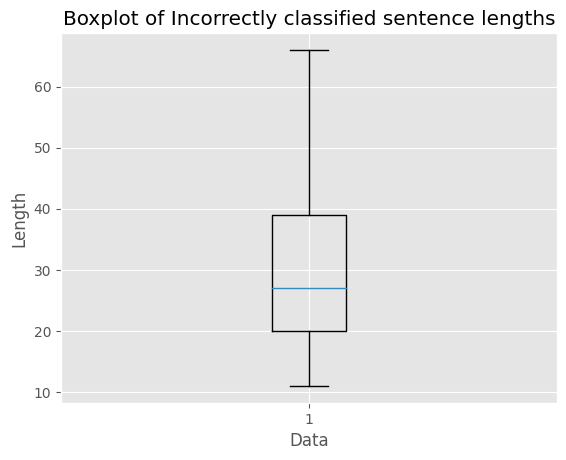

In [ ]:
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
nltk.download('punkt')

misclassified_indexes = []
lengths = []
for index, (true_class, pred_class) in enumerate(zip(true_labels, predictions_labels)):
  if true_class != pred_class:
    misclassified_indexes.append(index)
    lengths.append(len(word_tokenize(str(valid_dataset.texts[index]))))
    print(f"Misclassified, pred:{pred_class} true:{true_class} data: {valid_dataset.texts[index]}")





plt.boxplot(lengths, showfliers=False)

plt.title('Boxplot of Incorrectly classified sentence lengths')
plt.xlabel('Data')
plt.ylabel('Length')

# Show the plot